In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq, fsolve
import math

%matplotlib inline

Part 1.1

In [3]:
fn = 'IR Data.xlsx'

In [4]:
ois = pd.read_excel(fn, header = 0, sheet_name = 'OIS')

In [5]:
ois['years'] = ois.Tenor.apply(lambda x: float(str(x)[:-1]) if x != '6m' else 0.5)
month_days, year_days = (ois.iloc[0,5]).split('/')
month_days, year_days = float(month_days) , float(year_days)

In [6]:
ois

,Tenor,Product,Rate,Unnamed: 3,Unnamed: 4,Unnamed: 5,years
0,6m,OIS,0.00250,NaN,Day Count Convention,30/360,0.5
1,1y,OIS,0.00300,NaN,O/N Leg Frequency,Daily,1.0
2,2y,OIS,0.00325,NaN,Fixed Leg Frequency,Annual,2.0
3,3y,OIS,0.00335,NaN,NaN,NaN,3.0
4,4y,OIS,0.00350,NaN,NaN,NaN,4.0
5,5y,OIS,0.00360,NaN,NaN,NaN,5.0
6,7y,OIS,0.00400,NaN,NaN,NaN,7.0
7,10y,OIS,0.00450,NaN,NaN,NaN,10.0
8,15y,OIS,0.00500,NaN,NaN,NaN,15.0
9,20y,OIS,0.00525,NaN,NaN,NaN,20.0


In [7]:
tenor_list = list(ois.years.values)
rates_list = list(ois.Rate.values)
ON_leg_freq, fixed_leg_freq = ois.iloc[[1,2], 5]

In [9]:
tenor_list

[0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 10.0, 15.0, 20.0, 30.0]

In [10]:
tenor_diff = [math.ceil(tenor_list[i+1] - tenor_list[i]) for i in range(len(tenor_list)-1)]
tenor_diff

[1, 1, 1, 1, 1, 2, 3, 5, 5, 10]

In [434]:
def interp(previous, current, steps):
    values = []
    steps = int(steps)
    for i in range(steps):
        values.append(((i+1)/(steps)) * (current - previous) + previous)

    return values

In [109]:
def discount_from_ois(x, DF, year_days, tenor_list, float_list, rates_list, delta, ois, missing_tenors, tenor_DF):

    tenor_diff = [math.ceil(tenor_list[i+1] - tenor_list[i]) for i in range(len(tenor_list)-1)]
    
    known = np.array([DF[i+1] * (((1 + (float_list[i+1]/year_days))**(year_days)) - 1) for i in range(len(DF)-1)])
    
    # float rate across the tenor
#     float_n = (((DF[-1]/x) ** (1/(tenor_diff[len(tenor_DF) - 1]* delta * year_days))) - 1) * year_days

    DF_update = np.array(interp(DF[-1], x, (missing_tenors + 1))) # generated interpolated and latest discount factors

    # here, float rates are calculated starting from the difference between two discount factors. e.g. f1 calculated from D(0,1) and D(0,2)
    float_rates = np.array([(((DF[-1]/DF_update[i])**(1/(delta * year_days)) - 1) * year_days) if i==0 else \
                            (((DF_update[i-1]/DF_update[i])**(1/(delta * year_days)) - 1) * year_days)\
                            for i in range(len(DF_update))]) #obtain float rates for interpolated discount factors

#     unknown = new_DFs_sum * (((1 + float_n/year_days)**(year_days)) - 1) # each discount factor applied to float rate (assumed constant)
    unknown = np.array([DF_update[i] * ((1 + float_rates[i]/year_days)** (delta * year_days) - 1) for i in range(len(DF_update))]).sum()

    DF_sum = np.array(DF[1:]).sum() #exclude tenor of 0.5year
    
    float_leg = known.sum() + unknown
    fixed_leg = delta * ois * (DF_sum + DF_update.sum())

    return float_leg - fixed_leg

In [110]:
def ois_df_bootstrap(tenor_list,
                     rates_list,
                     fixed_leg_freq,
                     day_count_convention):
    
    month_days, year_days = (day_count_convention).split('/')
    month_days, year_days = float(month_days) , float(year_days)
    
    
    if (fixed_leg_freq == 'Annual'):
        delta = 1
    
    tenor_DF = []
    tenor_float_rates = []
    
    DF = []
    float_list = []
    
    previous_tenor = 1 # not used for tenors <= 1
    
    for tenor in tenor_list:
        if (tenor <= 1):
            ois = rates_list[tenor_list.index(tenor)]
            
            float_rate = ((tenor * ois + 1) ** (1/(tenor * year_days)) - 1) * year_days
            
            DF_tenor = 1/((1 + tenor * ois))

            float_list.append(float_rate)
            DF.append(DF_tenor)
            
            tenor_DF.append(DF_tenor)
            tenor_float_rates.append(float_rate)

        elif tenor > 1:
            
            tenor_diff = tenor - previous_tenor
            missing_tenors = int(tenor_diff/delta - 1)
            
            ois = rates_list[tenor_list.index(tenor)]
        
            f = lambda x: discount_from_ois(x, DF, year_days, tenor_list, float_list, rates_list, delta, ois, missing_tenors, tenor_DF)
            current_DF = brentq(f, 0.1, 1)


            tenor_diff = [math.ceil(tenor_list[i+1] - tenor_list[i]) for i in range(len(tenor_list)-1)]
#             float_rate = (((DF[-1]/current_DF) ** (1/(tenor_diff[len(tenor_DF) - 1] * year_days))) - 1) * year_days
            
            DF_update = interp(DF[-1], current_DF, missing_tenors + 1) # list of missing tenors and latest tenor discount factors
            float_rates_update = np.array([((DF[-1]/DF_update[i])**(1/(delta * year_days)) - 1) * year_days if i==0 else \
                                           (((DF_update[i-1]/DF_update[i])**(1/(delta * year_days)) - 1) * year_days) \
                                           for i in range(len(DF_update))])
            
            
            # append same float rates based on missing tenors to match float_list and DF shape
            # since floating rate assumed to be constant between tenors
            for j in range(len(float_rates_update)):
                float_list.append(float_rates_update[j])
            
            DF = DF + DF_update
#             DF.append(current_DF)
            
            # store DF and float rates that are for the relevant tenors only (excludes interpolated results)
            tenor_DF.append(current_DF)
            tenor_float_rates.append(float_rates_update[-1])
            
            previous_tenor = tenor
#             print(len(float_list), len(DF)) # should give the same length
            
    return tenor_DF, DF, tenor_float_rates, float_list

In [111]:
day_count_convention = ois.iloc[0,5]

In [112]:
tenor_ois_DF, ois_DF, tenor_float_list, float_list = ois_df_bootstrap(tenor_list, rates_list, fixed_leg_freq, day_count_convention)

In [113]:
tenor_ois_DF

[0.9987515605493134,
 0.9970089730807579,
 0.993530745913246,
 0.9900151412182416,
 0.9861166497151829,
 0.9821841197331824,
 0.9724057745942708,
 0.9559768785261538,
 0.9276114796053047,
 0.9000759370412345,
 0.8474067157361065]

In [114]:
ois_DF

[0.9987515605493134,
 0.9970089730807579,
 0.993530745913246,
 0.9900151412182416,
 0.9861166497151829,
 0.9821841197331824,
 0.9772949471637267,
 0.9724057745942708,
 0.9669294759048984,
 0.9614531772155261,
 0.9559768785261538,
 0.9503037987419839,
 0.9446307189578141,
 0.9389576391736443,
 0.9332845593894745,
 0.9276114796053047,
 0.9221043710924907,
 0.9165972625796766,
 0.9110901540668626,
 0.9055830455540484,
 0.9000759370412345,
 0.8948090149107216,
 0.8895420927802089,
 0.8842751706496961,
 0.8790082485191832,
 0.8737413263886704,
 0.8684744042581577,
 0.8632074821276449,
 0.857940559997132,
 0.8526736378666193,
 0.8474067157361065]

In [115]:
float_list

[0.0024984474705913584,
 0.0029955214424148835,
 0.0034947783831640322,
 0.0035447888626816138,
 0.003945605189130674,
 0.0039958903644343735,
 0.004990322872213682,
 0.005015351145907232,
 0.005647663238992351,
 0.005679740586810311,
 0.005712184400126219,
 0.0059520546976710165,
 0.005987693885032286,
 0.006023762438935876,
 0.006060268165777316,
 0.006097219062120018,
 0.005954612248322277,
 0.005990282161905114,
 0.0060263819991046574,
 0.006062919579745696,
 0.006099902914540323,
 0.005868877750740964,
 0.0059035249167571635,
 0.005938583595437308,
 0.005974061161921895,
 0.0060099651688894085,
 0.006046303351432414,
 0.006083083633132702,
 0.006120314131337068,
 0.006158003163472259,
 0.006196159253120115]

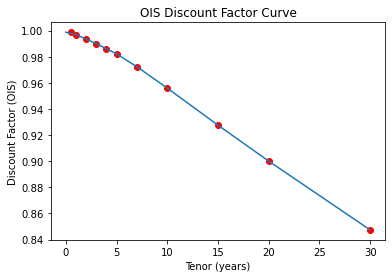

In [116]:
start, stop, step = 0, 30, 1
t_range = np.arange(start, stop+step, step)
plt.scatter(ois.years, tenor_ois_DF, c = 'red')
# plt.plot(ois.years, tenor_ois_DF)
plt.plot(t_range, ois_DF)
plt.xlabel('Tenor (years)')
plt.ylabel('Discount Factor (OIS)')
plt.title('OIS Discount Factor Curve')
plt.show()

In [126]:
irs = pd.read_excel(fn, header = 0, sheet_name = 'IRS')

In [127]:
irs['years'] = irs.Tenor.apply(lambda x: float(str(x)[:-1]) if x != '6m' else 0.5)
month_days, year_days = (irs.iloc[0,5]).split('/')
month_days, year_days = float(month_days) , float(year_days)

In [128]:
irs

,Tenor,Product,Rate,Unnamed: 3,Unnamed: 4,Unnamed: 5,years
0,6m,LIBOR,0.0250,NaN,Day Count Convention,30/360,0.5
1,1y,IRS,0.0280,NaN,Fixed Leg Freq,Semi-annual,1.0
2,2y,IRS,0.0300,NaN,Floating Leg Freq,Semi-annual,2.0
3,3y,IRS,0.0315,NaN,NaN,NaN,3.0
4,4y,IRS,0.0325,NaN,NaN,NaN,4.0
5,5y,IRS,0.0330,NaN,NaN,NaN,5.0
6,7y,IRS,0.0350,NaN,NaN,NaN,7.0
7,10y,IRS,0.0370,NaN,NaN,NaN,10.0
8,15y,IRS,0.0400,NaN,NaN,NaN,15.0
9,20y,IRS,0.0450,NaN,NaN,NaN,20.0


Part 1.2

In [141]:
# def discount_from_irs(DF, delta, missing_tenors, swap_rate, x):
#     float_leg = 1 - x
#     fixed_leg = delta * swap_rate * np.array((*DF, *interp(DF[-1], x, missing_tenors), x)).sum()

#     return (float_leg - fixed_leg)

In [142]:
# def df_bootstrap(tenor_list,
#                  rates_list,
#                  fixed_leg_freq,
#                  floating_leg_freq):
    
#     DF = []
    
#     if (fixed_leg_freq == 'Semi-annual') and (floating_leg_freq == 'Semi-annual'):
#         delta = 0.5
    
#     previous_tenor = 1
    
#     for tenor in tenor_list:

#         if (tenor < 1) and (tenor == 0.5):
#             libor = rates_list[tenor_list.index(tenor)]
#             DF.append(1/((1 + libor*tenor)))
        
#         if (tenor == 1):
#             swap_rate = rates_list[tenor_list.index(tenor)]
#             numerator = 1 - swap_rate * delta * DF[0]
#             denominator = 1 + delta * swap_rate
#             DF.append(numerator/denominator)
        
#         elif tenor > 1:
#             tenor_diff = tenor - previous_tenor
#             missing_tenors = int(tenor_diff/delta - 1)

#             swap_rate = rates_list[tenor_list.index(tenor)]
            
#             f = lambda x: discount_from_irs(DF, delta, missing_tenors, swap_rate, x)
#             current_DF = brentq(f, 0, 1)

#             DF = DF + interp(DF[-1], current_DF, missing_tenors)
            
#             DF.append(current_DF)
                      
#             previous_tenor = tenor
                      
    
#     return DF

In [266]:
import itertools

def interp_ois_DF(tenor_ois_DF, tenor_list, new_delta, tenor_6m = True):
    ''' tenor_6m == True means 0.5y tenor is in discount factor list'''
    
    tenor_diff = np.array([math.ceil(tenor_list[i+1] - tenor_list[i]) for i in range(len(tenor_list)-1)])
    missing_tenors = (tenor_diff/new_delta - 1)
    
    if tenor_6m == True:
        if new_delta == 0.5:

            ois_DF_new = [[tenor_ois_DF[i]] if i <= 1 else \
                          interp(tenor_ois_DF[i-1], tenor_ois_DF[i], int(missing_tenors[i-1] + 1))\
                          for i in range(len(tenor_ois_DF))]
    return list(itertools.chain(*ois_DF_new)) # unpack lists within

In [267]:
def discount_from_irs(DF, float_rates, tenor_ois_DF, tenor_list, delta, missing_tenors, swap_rate, x):
    
    ois_DF_ = interp_ois_DF(tenor_ois_DF, tenor_list, delta) #obtain OIS discount factors for new delta

    interp_libor_DF = interp(DF[-1], x, int(missing_tenors + 1)) # includes current_DF

    unknown_float = [DF[-1]/interp_libor_DF[i] - 1 if i==0 else \
                    interp_libor_DF[i-1]/interp_libor_DF[i] - 1 \
                    for i in range(len(interp_libor_DF))] # use interpolated libor discount factors to calculate (delta * f)
    
    
#     print(ois_DF_, unknown_float)
    known = np.array([ois_DF_[i] * (delta * float_rates[i]) for i in range(len(DF))])
    unknown = np.array([ois_DF_[j] * unknown_float[j - len(DF)] for j in range(len(DF), len(DF) + missing_tenors + 1)])

    float_leg = known.sum() + unknown.sum()

    fixed_leg = delta * swap_rate * np.array(ois_DF_[:(len(DF) + missing_tenors + 1)]).sum()
#     print(fixed_leg)
    return (float_leg - fixed_leg)

In [584]:
def df_bootstrap(tenor_list,
                 rates_list,
                 fixed_leg_freq,
                 floating_leg_freq,
                 tenor_ois_DF):
    
    DF = []
    float_rates = []
    tenor_DF = []
    
    if (fixed_leg_freq == 'Semi-annual') and (floating_leg_freq == 'Semi-annual'):
        delta = 0.5
    
    previous_tenor = 1
    
    for tenor in tenor_list:

        if tenor == 0.5:
            libor = rates_list[tenor_list.index(tenor)]            
            DF_ = 1/((1 + libor*tenor))
            
            DF.append(DF_)
            float_rates.append(libor)
            tenor_DF.append(DF_)
        
        if (tenor == 1):
            swap_rate = rates_list[tenor_list.index(tenor)]
            
            fixed_leg = swap_rate * delta * np.sum(tenor_ois_DF[:2])
            first_float_leg = tenor_ois_DF[0] * float_rates[0] * delta
            DF_ = DF[0]/(((fixed_leg - first_float_leg)/tenor_ois_DF[0]) + 1)
            
#             numerator = swap_rate * delta * DF[0]
#             denominator = 1 + delta * swap_rate
#             DF_ = numerator/denominator
            float_ = (DF[0]/DF_ - 1)/delta
            
            DF.append(DF_)
            float_rates.append(float_)
            tenor_DF.append(DF_)
        
        elif tenor > 1:
            tenor_diff = tenor - previous_tenor
            missing_tenors = int(tenor_diff/delta - 1)

            swap_rate = rates_list[tenor_list.index(tenor)]
            
            f = lambda x: discount_from_irs(DF, float_rates, tenor_ois_DF, tenor_list, delta, missing_tenors, swap_rate, x)
            current_DF = brentq(f, 1e-4, 1)

            DF_updates = interp(DF[-1], current_DF, int(missing_tenors + 1))
            float_updates = [((DF[-1]/DF_updates[i] - 1)/delta) if i == 0 else \
                             ((DF_updates[i-1]/DF_updates[i] - 1)/delta) \
                             for i in range(len(DF_updates))]
#             print(tenor, DF_updates)
            DF = DF + DF_updates
#             print(DF)
            float_rates = float_rates + float_updates
            tenor_DF.append(current_DF)
            previous_tenor = tenor
                      
    return tenor_DF, DF, float_rates

In [585]:
tenor_list = list(irs.years.values)
rates_list = list(irs.Rate.values)
fixed_leg_freq, floating_leg_freq = irs.iloc[[1,2], 5]

In [586]:
tenor_libor_DF, libor_DF, libor_float_rates = df_bootstrap(tenor_list,
                                           rates_list,
                                           fixed_leg_freq,
                                           floating_leg_freq,
                                           tenor_ois_DF)

In [587]:
libor_DF

[0.9876543209876544,
 0.9726027360730719,
 0.957390844132509,
 0.9421789521919461,
 0.9263302163324262,
 0.9104814804729062,
 0.8947310548128958,
 0.8789806291528854,
 0.8639849349901336,
 0.8489892408273818,
 0.8327959671968931,
 0.8166026935664044,
 0.8004094199359157,
 0.784216146305427,
 0.768965171291724,
 0.753714196278021,
 0.7384632212643181,
 0.7232122462506151,
 0.7079612712369121,
 0.6927102962232091,
 0.6785473330342555,
 0.6643843698453019,
 0.6502214066563482,
 0.6360584434673946,
 0.621895480278441,
 0.6077325170894874,
 0.5935695539005338,
 0.5794065907115801,
 0.5652436275226265,
 0.5510806643336729,
 0.5367943539971657,
 0.5225080436606584,
 0.5082217333241512,
 0.49393542298764403,
 0.47964911265113686,
 0.4653628023146296,
 0.4510764919781224,
 0.4367901816416152,
 0.422503871305108,
 0.4082175609686008,
 0.39898980372127363,
 0.38976204647394647,
 0.3805342892266193,
 0.37130653197929214,
 0.362078774731965,
 0.3528510174846378,
 0.3436232602373107,
 0.334395502989

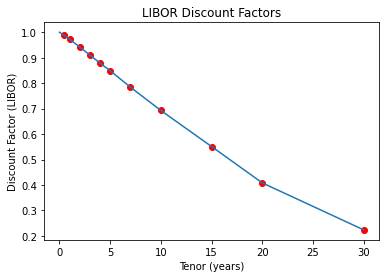

In [588]:
start, stop, step = 0, 30, 0.5
t_range = np.arange(start, stop+step, step)
libor_DF_ = [1] + libor_DF
plt.plot(t_range, libor_DF_)
plt.scatter(tenor_list, tenor_libor_DF, c = 'red')
plt.xlabel('Tenor (years)')
plt.ylabel('Discount Factor (LIBOR)')
plt.title('LIBOR Discount Factors')
plt.show()

Part 1.3

In [589]:
t = np.array((1,5,10))
T_t = np.array((1,2,3,5,10))

In [590]:
# tenor_libor_DF, tenor_ois_DF

In [591]:
tenor_list

[0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 10.0, 15.0, 20.0, 30.0]

In [592]:
def unpack_nested_list(container, nest_list): 
    for item in nest_list: 
        if type(item) == list: 
            unpack_nested_list(container, item) 
        else: 
            container.append(item) 

In [593]:
def forward_swap_rate(t,
                      T_t,
                      tenor_libor_DF,
                      tenor_ois_DF,
                      tenor_list,
                      delta = 1):
    
    T = T_t + t 
    previous_tenor = 0
    
    # convert to numpy array for ease of coding
    tenor_array = np.array(tenor_list)
    tenor_ois_array = np.array(tenor_ois_DF)
    tenor_libor_array = np.array(tenor_libor_DF)
    
    # extract tenors & discount factors that are between t and T
    mask = [t <= tenor <= T for tenor in tenor_array] # still need D(0,t) for float leg (float rate calculation)
    
    if T in tenor_array:
        tenors_ = tenor_array[mask]
        ois_ = tenor_ois_array[mask]
        libor_ = tenor_libor_array[mask]
        
    else:
        # interpolate DF based on previous and next DF for D(0, T) if T is not in tenor list
        tenors_ = np.append(tenor_array[mask], T)
        next_tenor = tenor_array[[tenor > T for tenor in tenor_array]][0]
        previous_tenor = tenor_array[mask][-1]
        tenor_gap = T - previous_tenor
        
        previous_ois_DF = tenor_ois_array[mask][-1]
        next_ois_DF = tenor_ois_array[[tenor > T for tenor in tenor_array]][0]
        interpolated_oisDF_T = (tenor_gap/(next_tenor-previous_tenor)) * (next_ois_DF - previous_ois_DF) + previous_ois_DF
        ois_ = np.append(tenor_ois_array[mask], interpolated_oisDF_T)
        
        previous_libor_DF = tenor_libor_array[mask][-1]
        next_libor_DF = tenor_libor_array[[tenor > T for tenor in tenor_array]][0]
        interpolated_liborDF_T = (tenor_gap/(next_tenor-previous_tenor)) * (next_libor_DF - previous_libor_DF) + previous_libor_DF
        libor_ = np.append(tenor_libor_array[mask], interpolated_liborDF_T)
    
    tenor_diff = np.array([tenors_[i+1] - tenors_[i] for i in range(len(tenors_)-1)])
    missing_tenors = tenor_diff/delta - 1

    # interpolate ois and libor discount factors to put into formula
    interp_ois = [interp(ois_[i-1], ois_[i], missing_tenors[i-1]+1) for i in range(1, len(ois_))]
    interp_ois_container = []
    unpack_nested_list(interp_ois_container, interp_ois)
    unpacked_ois = interp_ois_container
    if unpacked_ois == None:
        ois_list = [ois_[0]]
    else:
        ois_list = [ois_[0]] + unpacked_ois
            
    ois_DF = np.array(ois_list) # full ois_DF needed, D(0,t) INCLUSIVE (but not needed)

    interp_libor = [interp(libor_[i-1], libor_[i], missing_tenors[i-1]+1) for i in range(1, len(libor_))]
    interp_libor_container = []
    unpack_nested_list(interp_libor_container, interp_libor)
    unpacked_libor = interp_libor_container

    if unpacked_libor == None:
        libor_list = [libor_[0]]
    else:
        libor_list = [libor_[0]] + unpacked_libor
    
    
    libor_DF = np.array(libor_list) # full libor DF needed, D(0,t) INCLUSIVE

    # f(t, t+1)
    float_rates = [(1/delta) * (libor_DF[j]/libor_DF[j+1] - 1) for j in range(len(libor_DF) - 1)]
    
    # discounting always from D(0, t+1) to D(0, T)
    float_leg = np.array([ois_DF[i+1] * (delta * float_rates[i]) for i in range(len(ois_DF)-1)]).sum() #discounting from t+i
    fixed_leg_coefficient = delta * np.array(ois_DF[1:]).sum() # exclude D(0,t)

    forward_swap_rate = float_leg/fixed_leg_coefficient
    
    return forward_swap_rate
    

In [594]:
# test
t1 = 5
T_t1 = 1

In [595]:
forward_swap_rate(t1, T_t1, tenor_libor_DF, tenor_ois_DF, tenor_list)

0.0396601033968349

In [596]:
forward_swap_rates = np.zeros((len(t), len(T_t)))
for i in range(len(t)):
    for j in range(len(T_t)):
        forward_swap_rates[i][j] = forward_swap_rate(t[i],
                                                     T_t[j],
                                                     tenor_libor_DF,
                                                     tenor_ois_DF,
                                                     tenor_list)

forward_swap_rates

array([[0.03229088, 0.03355019, 0.03430986, 0.03557312, 0.038803  ],
       [0.0396601 , 0.04047699, 0.04047429, 0.0415164 , 0.04411307],
       [0.04263485, 0.04358135, 0.04458457, 0.04678677, 0.05419083]])

In [597]:
results = pd.DataFrame(forward_swap_rates, index = t, columns = T_t)

In [598]:
results

,1,2,3,5,10
1,0.032291,0.033550,0.034310,0.035573,0.038803
5,0.039660,0.040477,0.040474,0.041516,0.044113
10,0.042635,0.043581,0.044585,0.046787,0.054191
